In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib import style
style.use('seaborn')

In [29]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
Base = automap_base()

In [5]:
Base.prepare(engine, reflect=True)

In [6]:
Base.classes.keys()

['measurement', 'station']

In [7]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
session = Session(engine)

In [10]:
# Precipitation Analysis


# find out the last date in database
last_date = (session
            .query(Measurement.date)
            .order_by(Measurement.date.desc()).first())
print(last_date)

('2017-08-23',)


In [13]:
# i need th elast 12 months
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(year_ago)

2016-08-23


In [14]:

results_of_last_year = (session
                       .query(Measurement.date, Measurement.prcp)
                       .filter(Measurement.date > year_ago)
                       .order_by(Measurement.date).all())
# this is a list

In [15]:
results_df = pd.DataFrame(results_of_last_year)
results_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,1.22
4,2016-08-24,2.15


In [17]:
# for plot i need to set index date
results_df.set_index('date').head(5)

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


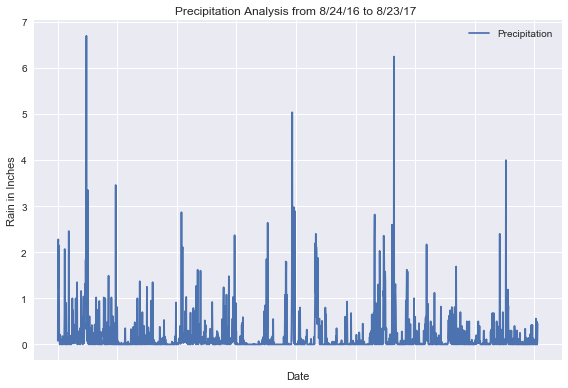

In [24]:
# plot chart of results
results_df.plot('date', 'prcp')
plt.xlabel('Date')
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis from 8/24/16 to 8/23/17 ")
plt.legend(["Precipitation"])
plt.tight_layout()
plt.show()

In [20]:
results_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [27]:
# Station Analysis

total_station = (session
                .query(Station.station)
                .count())
print(f'There are {total_station} stations in Hawaii')

There are 9 stations in Hawaii


In [41]:
busy_station = (session
                .query(Measurement.station, func.count(Measurement.tobs))
                .group_by(Measurement.station)
                .order_by(func.count(Measurement.tobs).desc()).all()
               )

print('Here is the list of station with their observation number ')
# i need to do unpacking and itterows.
for station, observation in busy_station:
    print(f'Staion {station} has {observation} observations')



Here is the list of station with their observation number 
Staion USC00519281 has 2772 observations
Staion USC00513117 has 2696 observations
Staion USC00519397 has 2685 observations
Staion USC00519523 has 2572 observations
Staion USC00516128 has 2484 observations
Staion USC00514830 has 1937 observations
Staion USC00511918 has 1932 observations
Staion USC00517948 has 683 observations
Staion USC00518838 has 342 observations


In [42]:
busiest = busy_station[0][0]

print(f'The most active station is {busiest}')

The most active station is USC00519281


In [44]:
temp_obs = (session
            .query(Measurement.station, Measurement.date, Measurement.tobs)
            .filter(Measurement.station == busiest)
            .filter(Measurement.date > year_ago)
            .order_by(Measurement.date).all())

In [46]:
temp_obs_df = pd.DataFrame(temp_obs)
temp_obs_df.head()

,station,date,tobs
0,USC00519281,2016-08-24,77
1,USC00519281,2016-08-25,80
2,USC00519281,2016-08-26,80
3,USC00519281,2016-08-27,75
4,USC00519281,2016-08-28,73


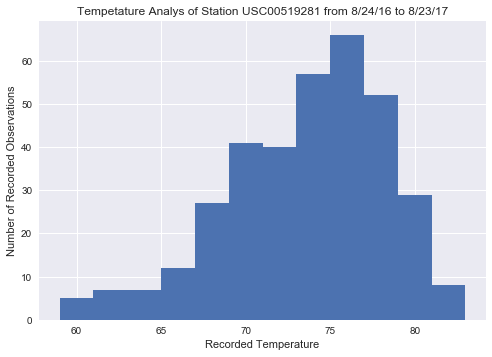

In [48]:
plt.hist(temp_obs_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Tempetature Analys of Station " +busiest+ " from 8/24/16 to 8/23/17")
plt.show()

In [75]:
# Temperature Analysis
# calc_temps function

def calc_temps(start_date, end_date):
    return (session
            .query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs))
           .filter(Measurement.date >= start_date)
           .filter(Measurement.date <= end_date)
           .all()
           )


In [76]:
# let say my trip start 2018-08-02, and would end 2018-08-09
trip_start = dt.date(2018, 8, 2)
trip_end = dt.date(2018, 8, 9)
one_year = dt.timedelta(days=365)
start_date = trip_start - one_year
end_date = trip_end - one_year

temps_for_trip = calc_temps(start_date, end_date)
print("Minimum Temperatue is "+str(temps_for_trip[0][0]) + 
      " Average Temperature is "+str(temps_for_trip[0][2]) +
      " Maximum Temperature is "+str(temps_for_trip[0][1]) + 
      " between " +str(start_date)+ " and " +str(end_date)
     )

Minimum Temperatue is 71 Average Temperature is 83 Maximum Temperature is 79.6896551724138 between 2017-08-02 and 2017-08-09


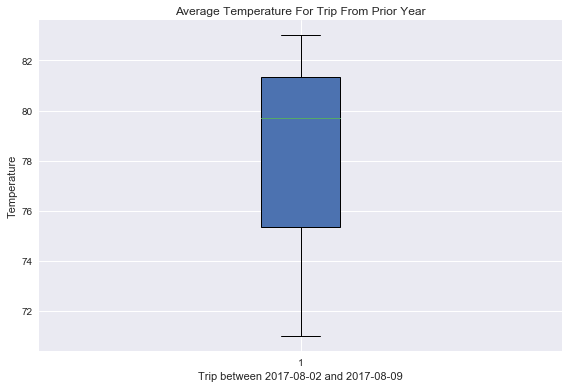

In [77]:
# plotting the data as a boxplot

fig, ax = plt.subplots()
x = range(len(temps_for_trip))
ax.boxplot(temps_for_trip, patch_artist=True)
ax.set_title('Average Temperature For Trip From Prior Year')
ax.set_ylabel("Temperature")
ax.set_xlabel("Trip" + " between " +str(start_date)+ " and " +str(end_date))
fig.tight_layout()
plt.show()

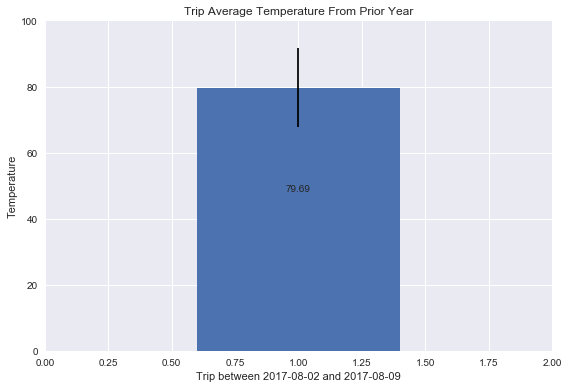

In [81]:

# plot the calculated min/max/avg from last year for the trip dates as a bar chart# plot t 


avg_temp = temps_for_trip[0][1]
min_temp = temps_for_trip[0][0]
max_temp = temps_for_trip[0][2]
peek_peek = temps_for_trip[0][2]-temps_for_trip[0][0]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avg_temp, yerr=peek_peek)
ax.set_xlabel("Trip" + " between " +str(start_date)+ " and " +str(end_date))
ax.set_ylabel("Temperature")
ax.set_title("Trip Average Temperature From Prior Year")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom')

        
    # label the bars 
autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.show()

In [90]:
# 
rainfall = (session
           .query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs)
           .filter(Measurement.date >= start_date)
           .filter(Measurement.date <= end_date)
           .order_by(Measurement.station).all())
print("All data from all station from previos year that macth our vacation dates")

for info in rainfall:
    
    print("Station= "+ info[0]+ " Date= " + info[1]+ " prcp= "+str(info[2])+ " tobs= " +str(info[3]))


All data from all station from previos year that macth our vacation dates
Station= USC00514830 Date= 2017-08-02 prcp= 0.05 tobs= 80
Station= USC00514830 Date= 2017-08-03 prcp= 0.01 tobs= 81
Station= USC00514830 Date= 2017-08-04 prcp= 0.04 tobs= 81
Station= USC00514830 Date= 2017-08-06 prcp= 0.0 tobs= 82
Station= USC00514830 Date= 2017-08-07 prcp= 0.0 tobs= 81
Station= USC00514830 Date= 2017-08-08 prcp= 0.1 tobs= 78
Station= USC00514830 Date= 2017-08-09 prcp= 0.0 tobs= 81
Station= USC00516128 Date= 2017-08-02 prcp= 0.25 tobs= 80
Station= USC00516128 Date= 2017-08-03 prcp= 0.06 tobs= 76
Station= USC00516128 Date= 2017-08-07 prcp= 0.05 tobs= 78
Station= USC00516128 Date= 2017-08-08 prcp= 0.34 tobs= 74
Station= USC00516128 Date= 2017-08-09 prcp= 0.15 tobs= 71
Station= USC00519281 Date= 2017-08-04 prcp= 0.0 tobs= 77
Station= USC00519281 Date= 2017-08-05 prcp= 0.06 tobs= 82
Station= USC00519281 Date= 2017-08-06 prcp= 0.0 tobs= 83
Station= USC00519397 Date= 2017-08-02 prcp= 0.0 tobs= 73
Stati

In [149]:
# daily_normals


def daily_normals(date):
    info_about_date = (session
                      .query(func.avg(Measurement.prcp), func.avg(Measurement.tobs))
                      .filter(func.strftime("%m-%d", Measurement.date) == date)
                      .all())
    return print("For " +str(date)+ " expecting temperature is "+ str(info_about_date))
            




In [151]:
# let's say our date is 08-02
# spe_date = "2018-08-02"
# datee = dt.datetime.strftime(spe_date,'%Y-%m-%d')
# date = f"{datee.month}-{datee.day}"
datee = dt.date(2018, 8 ,2)
date = datee.strftime("%m-%d")
print(date)
daily_normals(date)

08-02
For 08-02 expecting temperature is [(0.14759999999999998, 75.74)]


In [153]:
# Optional Recommended Analysis 

first_day = dt.date(2018, 8 ,2)
last_day = dt.date(2018, 8 ,9)
delta = last_day - first_day

df_trip = []
for i in range(delta.days + 1):
    day_1 = first_day + dt.timedelta(i)
    day = day_1.strftime("%m-%d")
    df_trip.append(daily_normals(day))


For 08-02 expecting temperature is [(0.14759999999999998, 75.74)]
For 08-03 expecting temperature is [(0.03627450980392157, 76.37254901960785)]
For 08-04 expecting temperature is [(0.11916666666666666, 76.625)]
For 08-05 expecting temperature is [(0.11000000000000003, 76.0625)]
For 08-06 expecting temperature is [(0.0852, 75.98)]
For 08-07 expecting temperature is [(0.11499999999999996, 77.12)]
For 08-08 expecting temperature is [(0.11041666666666665, 76.35416666666667)]
For 08-09 expecting temperature is [(0.16333333333333333, 75.95833333333333)]


[None, None, None, None, None, None, None, None]